# Project 2: Text Analysis of UN Speeches
by Matt Ring

# Setup

1. Load Packages

In [1]:
## Packages
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyLDAvis.sklearn

2. Import Data

In [2]:
## Data

df = pd.read_csv("data/un_gen_debates_text.csv")

In [3]:
# Display the data
df.sample(10)

,session,year,country,country_name,speaker,position,text
6816,67,2012,JAM,Jamaica,Simpson Miller,Prime Minister,﻿Allow me to\ncongratulate the President on hi...
622,30,1975,JOR,Jordan,Mr. SHARE,NaN,"1.\t Sir, may I extend to you my congratulatio..."
1015,33,1978,GTM,Guatemala,Castillo-Valdes,NaN,"﻿87.\tMr. President, it is a particular pleasu..."
5893,62,2007,MWI,Malawi,"Bingu Wa Mutharika,",President,I am happy to have this \nopportunity to addre...
945,32,1977,THA,Thailand,Pachariyangkun,NaN,"﻿150.\tMr. President, allow me at the outset t..."
5718,61,2006,PNG,Papua New Guinea,"Grand Chief Rt. HON. SIR MICHAEL T. SOMARE, GO...",Prime Minister,I \nwish to convey Papua New Guinea’s congratu...
5757,61,2006,UGA,Uganda,Mr. Sam Kutesa MP,Minister for Foreign Affairs,Let me first of all \ncongratulate Ms. Haya Ra...
4559,55,2000,LUX,Luxembourg,Hubert Wurth,UN Representative,"Ms. Lydie Polfer, Vice-Prime Minister and Mini..."
518,29,1974,NGA,Nigeria,Mr. Arikpo,NaN,"On behalf of the Nigerian delegation, I congra..."
3495,49,1994,MCO,Monaco,Crown Prince Albert,Head of State,"At the outset, I should like to extend my sinc..."


3. Clean Data

In [4]:
# Remove newline and tab characters
df["text"] = df["text"].replace({"\n":" ",
                                 "\t":" ",
                                 "south africa": "southafrica",
                                 "South Africa": "southafrica"}, regex = True)

4. Subset Data

Political transitions in the Former Soviet Union (FSU) and other socialist states will be assessed. This was selected as I noticed Yugoslavia still present even in 2015. I had originally intended to look at other political transitions, but considered that too broad. As such, I've selected all modern states which were once or are Marxist-Leninist. States which only reference socialism in their constitution are not included, such as India, Portugal, Algeria, etc...

Some adjustments need to be made and noted here:
1. Germany is not included, as it is difficult to handle reunification here when each state had separate speaches.
2. Former Yugoslavic states will be noted as such. Yugoslavia is recorded until 1991, then representing Serbia from 2001 onwards. The other states include Slovenia, North Macedonia, Bosnia and Herzegovina, Croatia, and Montenegro.
3. Former USSR states will be noted as such. These include Russia, Armenia, Azerbeijan, Belarus, Estonia, Georgia, Kazakhstan, Kyrgyzstan, Latvia, Lithuania, Moldova, Tajikistan, Turkmenistan, Ukraine, and Uzbekistan.
4. Czechloslovakia becomes Chezia in the data around the year of 1992. These countries will be considered the same and continuous.

In [5]:
# Label former Yugolavic states
yugo = ["SVN", "MKD", "BIH", "HRV", "MNE", "YUG"]
df["former_yugoslavia"] = np.where(df["country"].isin(yugo), 1, 0)

In [6]:
# Label former USSR states
ussr = ["RUS", "ARM", "AZE", "BLR", "EST", "GEO", "KAZ", "KGZ", "LVA", "LTU", "MDA", "TJK", "TKM", "UKR", "UZB"]
df["former_ussr"] = np.where(df["country"].isin(ussr), 1, 0)

In [7]:
# Reassign all CSK to CZE (Czechia)
df["country"] = np.where(df["country"] == "CSK", "CZE", df["country"])

In [8]:
# Create a list of former (and present) socialist states
fss = ["RUS", "CHN", "YUG", "POL", "CUB", 
       "AFG", "ALB", "AGO", "ARM", "AZE",
       "BLR", "BEN", "BIH", "BGR", "KHM", 
       "COG", "CZE", "EST", "ETH", "GRD", 
       "GEO", "HUN", "HRV", "KAZ", "KGZ", 
       "LVA", "LTU", "MDA", "MKD", "MNG", 
       "MOZ", "ROU", "SOM", "MNE", "SVN", 
       "TJK", "TKM", "UKR", "UZB", 
       "VNM", "YEM", "LAO", "PRK"]

In [9]:
df

,session,year,country,country_name,speaker,position,text,former_yugoslavia,former_ussr
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,0,0
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177. : It is a fortunate coincidence that pre...,0,0
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100. It is a pleasure for me to extend to yo...,0,0
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155. May I begin by expressing to Ambassador...,0,0
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...",0,0
...,...,...,...,...,...,...,...,...,...
7502,70,2015,YEM,Yemen,Mr. Abdrabuh Mansour Hadi Mansour,President,On behalf of the people and the Government of ...,0,0
7503,70,2015,YUG,Yugoslavia,Mr. Tomislav Nikolić,President,Seventy years have passed since the establish...,1,0
7504,70,2015,ZAF,South Africa,Jacob Zuma,President,I should like to congratulate the President an...,0,0
7505,70,2015,ZMB,Zambia,Mr. Edgar Chagwa Lungu,President,I would like to begin by thanking the Secretar...,0,0


Now, we'll classify countries over time as socialist or not based on [this](https://en.wikipedia.org/wiki/List_of_socialist_states#Marxist%E2%80%93Leninist_states_2) list. Any not on this list will be research independently. Republics within the USSR will be classified based on information found [here](https://en.wikipedia.org/wiki/Republics_of_the_Soviet_Union).

In [10]:
df_fss = df.loc[df["country"].isin(fss)]

For each country, we want to know when they were and were not socialist. As such, we'll create a binary category recording this information based on the aformentioned lists.

**NOTE:** A state must have been socialist for more than half the year (before or after July 1st) for that year to count.

In [11]:
# USSR & Eastern Bloc (1991/2 collapse) - Former USSR, Former Yugoslavia, Albania, Congo, Mongolia
df_fss["socialist"] = np.where((df_fss["country"].isin(["ALB", "COG", "MNG"] + ussr + yugo)) & (df_fss["year"] <= 1991), 1, 0)

# Still/Always Socialist: China, Cuba, Laos, Vietnam, and North Korea
df_fss["socialist"] = np.where((df_fss["country"].isin(["CHN", "CUB", "LAO", "VNM", "PRK"])), 1, df_fss["socialist"])

# Poland, Yemen
df_fss["socialist"] = np.where((df_fss["country"].isin(["POL", "YEM"])) & (df_fss["year"] <= 1989), 1, df_fss["socialist"])

# Afghanistan
df_fss["socialist"] = np.where((df_fss["country"] == "AFG") & (df_fss["year"] <= 1991) & (df_fss["year"] >= 1978), 1, df_fss["socialist"])

# Angola
df_fss["socialist"] = np.where((df_fss["country"] == "AGO") & (df_fss["year"] <= 1992) & (df_fss["year"] >= 1976), 1, df_fss["socialist"])

# Benin
df_fss["socialist"] = np.where((df_fss["country"] == "BEN") & (df_fss["year"] <= 1990) & (df_fss["year"] >= 1976), 1, df_fss["socialist"])

# Bulgaria, Somalia
df_fss["socialist"] = np.where((df_fss["country"].isin(["BGR", "SOM"])) & (df_fss["year"] <= 1990), 1, df_fss["socialist"])

# Cambodia
df_fss["socialist"] = np.where((df_fss["country"] == "KHM") & (df_fss["year"] <= 1991) & (df_fss["year"] >= 1975), 1, df_fss["socialist"])

# Czechia, Hungary, Romania
df_fss["socialist"] = np.where((df_fss["country"].isin(["CZE", "HUN", "ROM"])) & (df_fss["year"] <= 1989), 1, df_fss["socialist"])

# Ethiopia
df_fss["socialist"] = np.where((df_fss["country"] == "ETH") & (df_fss["year"] <= 1990) & (df_fss["year"] >= 1974), 1, df_fss["socialist"])

# Grenada
df_fss["socialist"] = np.where((df_fss["country"] == "GRD") & (df_fss["year"] <= 1983) & (df_fss["year"] >= 1979), 1, df_fss["socialist"])

# Mozambique
df_fss["socialist"] = np.where((df_fss["country"] == "MOZ") & (df_fss["year"] <= 1990) & (df_fss["year"] >= 1975), 1, df_fss["socialist"])

C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/2006686030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fss["socialist"] = np.where((df_fss["country"].isin(["ALB", "COG", "MNG"] + ussr + yugo)) & (df_fss["year"] <= 1991), 1, 0)
C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/2006686030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fss["socialist"] = np.where((df_fss["country"].isin(["CHN", "CUB", "LAO", "VNM", "PRK"])), 1, df_fss["socialist"])
C:\Users\Matt\AppData\Local\Temp/ipykernel_

Finally, reset the index! This'll be useful later.

In [12]:
df_fss = df_fss.set_index(np.arange(0, len(df_fss)))

In [13]:
df_fss.sample(10)

,session,year,country,country_name,speaker,position,text,former_yugoslavia,former_ussr,socialist
861,55,2000,YEM,Yemen,Abdalla Saleh Al-Ashtal,UN Representative,"Permit me, at the outset, to extend to you, Mr...",0,0,0
1422,69,2014,COG,Congo,Denis Sassou Nguesso,President,I would like to extend my warmest congratulati...,0,0,0
928,57,2002,LVA,Latvia,Vaira Vike-Freiberga,President,﻿I would like to begin by congratulating the S...,0,1,0
1058,60,2005,PRK,"Korea, Democratic People's Republic of",NaN,Minister for Foregn Affairs,On behalf of the delegation of the Democratic ...,0,0,1
1438,69,2014,MKD,North Macedonia,Gjorge Ivanov,President,I am greatly honoured to address this forum a...,1,0,0
151,32,1977,HUN,Hungary,Puja,NaN,"﻿24. Mr. President, on behalf of the Hungaria...",0,0,1
838,55,2000,GEO,Georgia,Irakli Menagarishvili,Minister for Foreign Affairs,"At the outset, allow me to extend my warmest c...",0,1,0
155,32,1977,MOZ,Mozambique,MACHEL,President,﻿1. In addressing this Assembly for the first ...,0,0,1
101,30,1975,CUB,Cuba,Mr. ALARC6N,NaN,"96. First of all, I wish to express the sati...",0,0,1
1226,64,2009,MNE,Montenegro,Milo Dukanovic,Prime Minister,"At the outset, please allow me to congratulat...",1,0,0


In [14]:
len(df_fss)

1497

## Functions

In [15]:
def interpret_topics(vec, lda):
    ## Get feature names (vocabulary)
    voc = np.array(vec.get_feature_names())
    
    # Set number of top words you want
    n_words=10

    # Create lambda function to extra top words from voc
    imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]
    
    # Use imp_words to extract words with the highest weights from our lda model
    words_in_topic = ([imp_words(x) for x in lda.components_])
    
    return(words_in_topic)

In [16]:
def topic_dataset(df, topics, X, doc_topics):
    
    cols = ["Topic_" + str(each) for each in topics]
    docs = [str(each) for each in range(X.shape[0])]
    
    # Create dataframe with term weights and document # and topic # as rows, columns
    df_topics = pd.DataFrame(np.round(doc_topics, 2),
                            columns=cols,
                            index=docs)
    
    # Extract most important topics from those values
    imp_topic = np.argmax(df_topics.values, axis=1)
    
    df_topics["top_topic"] = imp_topic
    
    # Change the type of the topics index
    df_topics = df_topics.reset_index()
    df_topics['index'] = df_topics['index'].astype(str)
    
    # Bind topics by column to documents    
    df_final = pd.concat([df, df_topics], axis = 1).drop(["index"], axis = 1)
    
    return(df_final)

In [17]:
def long_form(df,
              drop_cols = ["country", "country_name", 
                           "speaker", "position",
                           "text",
                           "session", "former_yugoslavia", 
                           "former_ussr", "top_topic"],
              renames = {"year":"Year",
                         "speaker":"Speaker",
                         "position":"Position",
                         "country":"Country Abbreviation",
                         "country_name":"Country",
                         "session":"Session",
                         "former_yugoslavia": "Formerly Yugoslavia",
                         "former_ussr":"Formerly USSR",
                         "top_topic":"Top Topic",
                         "Topic_africa":"Africa", 
                         "Topic_global_cooperation":"Global Cooperation",
                         "Topic_cooperation":"Cooperation",
                         "Topic_nuclear_relations":"Nuclear Weapons",
                         "Topic_liberation":"Liberation",
                         "Topic_independence":"Independence",
                         "Topic_human_rights":"Human Rights",
                         "Topic_se_asia_afghan":"SE Asia",
                         "Topic_terrorism":"Terrorism",
                         "Topic_non_alligned":"Non-Alligned Movement",
                         "Topic_development":"Development",
                         "Topic_korea":"Korea"},
             rename_final = {"value":"Presence in Speeches",
                             "variable":"Topic"}):
    
    '''
    Takes in a dataframe and converts to long form
    '''
    
    # Drop irrelevant columns and least important topics
    df_long = df.drop(drop_cols, axis = 1)

    # Rename variables
    df_long = df_long.rename(renames, axis = 1)

    # Pivot to long form
    df_long = df_long.melt(id_vars='Year')
    
    # Rename columns
    df_long = df_long.rename({"variable":"Topic",
                              "value":"Presence in Speeches"}, axis = 1)
    
    return(df_long)

# Regional Analyses

Goal: Broad topics for speeches without getting overlap in topics or particular nations being defined and being consistently mentioned over time.

In [18]:
# Add stopwords related to institutions, such as UN councils, country names, etc.
# Also including words found across topics: peace, new, development

additional_stop_words = ["international", "united", "nations", "nation", "national", "countries", "country", "world", "states",
                         "council", "government", "people", "peoples", "republic", "general", "security", "soviet", "union",
                         "economic", "social", "assembly", "international", "community", "session", "organization", "peace", "new", "development"]

In [19]:
# Create a vectorizer
vec = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(additional_stop_words))

## Global

In [20]:
# Create dtm
X = vec.fit_transform(df_fss["text"])

In [21]:
# Create lda
lda = LatentDirichletAllocation(n_components=4,
                                n_jobs = -1,
                                random_state = 1000)

In [22]:
# Fit lda
doc_topics = lda.fit_transform(X)

In [23]:
# Return words per topic
interpret_topics(vec, lda)

[['nuclear',
  'relations',
  'political',
  'operation',
  'disarmament',
  'weapons',
  'efforts',
  'problems',
  'war',
  'peaceful'],
 ['struggle',
  'independence',
  'support',
  'aggression',
  'war',
  'situation',
  'viet',
  'military',
  'forces',
  'africa'],
 ['human',
  'rights',
  'state',
  'afghanistan',
  'war',
  'political',
  'today',
  'years',
  'law',
  'time'],
 ['cooperation',
  'efforts',
  'global',
  'human',
  'support',
  'rights',
  'important',
  'regional',
  'region',
  'process']]

In [24]:
# Name topics
topics = ["nuclear_relations", "independence", "human_rights", "cooperation"]

### New Dataset

In [25]:
# Merge topics as proportions to documents
df_final = topic_dataset(df_fss, topics, X, doc_topics)

### Visualizations

#### Defining Each Topic

In [26]:
lda_viz = pyLDAvis.sklearn.prepare(lda_model=lda,
                                   dtm=X,
                                   vectorizer=vec,
                                      sort_topics=False)

pyLDAvis.display(lda_viz)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


#### Trends Over Time

In [27]:
# Drop particular columns
df_year = df_final.drop(["socialist"], axis = 1)

# Convert to long form
df_year_long = long_form(df_year)

C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/380749161.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/global_topics.png", dpi = 400, width = 5, height = 3)
C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/380749161.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/global_topics.png", dpi = 400, width = 5, height = 3)


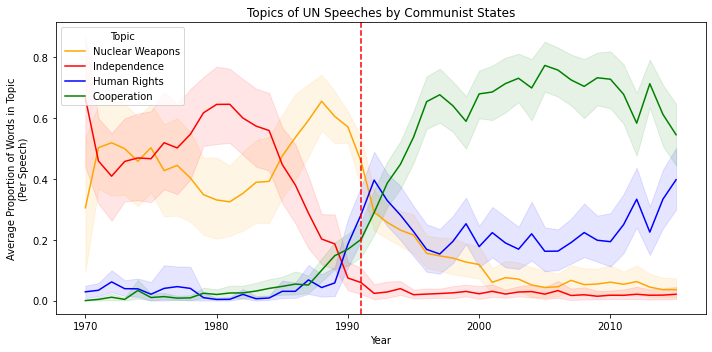

In [72]:
plt.figure(figsize = (10,5))

sns.lineplot(x = "Year", y = "Presence in Speeches", hue = "Topic", 
             data = df_year_long,
            palette = ["orange", "red", "blue", "green"],
             err_kws={'alpha':0.1})

plt.axvline(x = 1991,
           color = "red",
           linestyle = "--")

plt.title("Topics of UN Speeches by Communist States")
plt.ylabel("Average Proportion of Words in Topic\n(Per Speech)")

plt.tight_layout()
plt.savefig("plots/global_topics.png", dpi = 400, width = 5, height = 3)

## USSR & Sphere

In [29]:
# Create dtm
X_ussr = vec.fit_transform(df_fss["text"].loc[df_fss["country"].isin(ussr + ["ALB", "MNG", "POL", "AFG", "BGR", "CZE", "HUN", "ROU"])])

In [30]:
# Create lda
lda_ussr = LatentDirichletAllocation(n_components=3,
                                     n_jobs = -1,
                                     random_state = 1005)

In [31]:
# Fit lda
doc_topics_ussr = lda_ussr.fit_transform(X_ussr)

In [32]:
interpret_topics(vec, lda_ussr)

[['nuclear',
  'relations',
  'weapons',
  'disarmament',
  'operation',
  'military',
  'war',
  'political',
  'policy',
  'situation'],
 ['human',
  'rights',
  'political',
  'cooperation',
  'efforts',
  'europe',
  'conflict',
  'process',
  'european',
  'important'],
 ['afghanistan',
  'global',
  'human',
  'efforts',
  'terrorism',
  'rights',
  'cooperation',
  'support',
  'state',
  'years']]

In [33]:
# Name topics
topics_ussr = ["nuclear_relations", "human_rights", "terrorism"]

### New Dataset

In [34]:
# Merge topics as proportions to documents
df_temp = df_fss.loc[df_fss["country"].isin(ussr + ["ALB", "MNG", "POL", "AFG", "BGR", "CZE", "HUN", "ROU"])].reset_index(drop = True)
df_final_ussr = topic_dataset(df_temp, topics_ussr, X_ussr, doc_topics_ussr)

In [35]:
df_final_ussr.sample(3)

,session,year,country,country_name,speaker,position,text,former_yugoslavia,former_ussr,socialist,Topic_nuclear_relations,Topic_human_rights,Topic_terrorism,top_topic
660,65,2010,MNG,Mongolia,Batbold Sukhbaatar,Prime Minister,This session of the General Assembly is takin...,0,0,0,0.00,0.0,1.00,2
93,34,1979,BGR,Bulgaria,Zhivkova,NaN,"﻿Sir, permit me, first of all, to express the ...",0,0,1,1.00,0.0,0.00,0
606,63,2008,EST,Estonia,Toomas Hendrik Ilves,President,Allow me to begin by congratulating Mr. Migue...,0,1,0,0.03,0.0,0.97,2


### Visualizations

#### Defining Each Topic

In [36]:
lda_ussr_viz = pyLDAvis.sklearn.prepare(lda_model=lda_ussr,
                                   dtm=X_ussr,
                                   vectorizer=vec,
                                      sort_topics=False)

pyLDAvis.display(lda_ussr_viz)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


#### Trends Over Time

In [37]:
# Drop particular columns
df_year_ussr = df_final_ussr.drop(["socialist"], axis = 1)

# Convert to long form
df_year_ussr_long = long_form(df_year_ussr)

C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/136700532.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/ussr_topics.png", dpi = 400, width = 5, height = 3)
C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/136700532.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/ussr_topics.png", dpi = 400, width = 5, height = 3)


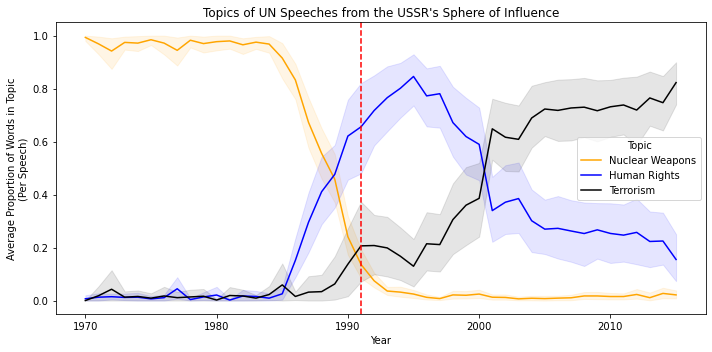

In [73]:
plt.figure(figsize = (10,5))

sns.lineplot(x = "Year", y = "Presence in Speeches", hue = "Topic", 
             data = df_year_ussr_long,
            palette = ["orange", "blue", "black"],
             err_kws={'alpha':0.1})

plt.axvline(x = 1991,
           color = "red",
           linestyle = "--")

plt.title("Topics of UN Speeches from the USSR's Sphere of Influence")
plt.ylabel("Average Proportion of Words in Topic\n(Per Speech)")

plt.tight_layout()
plt.savefig("plots/ussr_topics.png", dpi = 400, width = 5, height = 3)

## Yugoslavia

In [39]:
# Create dtm
X_yugo = vec.fit_transform(df_fss["text"].loc[df_fss["former_yugoslavia"] == 1])

In [40]:
# Create lda
lda_yugo = LatentDirichletAllocation(n_components=2,
                                     n_jobs = -1,
                                     random_state = 1100)

In [41]:
# Fit lda
doc_topics_yugo = lda_yugo.fit_transform(X_yugo)

In [42]:
interpret_topics(vec, lda_yugo)

[['human',
  'rights',
  'bosnia',
  'herzegovina',
  'croatia',
  'global',
  'european',
  'cooperation',
  'region',
  'serbia'],
 ['relations',
  'non',
  'political',
  'aligned',
  'problems',
  'war',
  'conference',
  'crisis',
  'rights',
  'yugoslavia']]

In [43]:
# Name topics
topics_yugo = ["human_rights", "non_alligned"]

### New Dataset

In [44]:
# Merge topics as proportions to documents
df_temp = df_fss.loc[df_fss["former_yugoslavia"] == 1].reset_index(drop = True)
df_final_yugo = topic_dataset(df_temp, topics_yugo, X_yugo, doc_topics_yugo)

In [45]:
df_final_yugo.sample(3)

,session,year,country,country_name,speaker,position,text,former_yugoslavia,former_ussr,socialist,Topic_human_rights,Topic_non_alligned,top_topic
4,29,1974,YUG,Yugoslavia,Mr. Minic,NaN,"Sir, I have the honor to congratulate you on y...",1,0,1,0.0,1.0,1
82,61,2006,BIH,Bosnia and Herzegovina,Mr. Adnam Terzic,Head of Government,It is a great honour and a pleasure to addres...,1,0,0,1.0,0.0,0
122,67,2012,SVN,Slovenia,Janez Janša,President,"﻿At the outset, let me congratulate His Excell...",1,0,0,1.0,0.0,0


### Visualizations

#### Defining Each Topic

In [46]:
lda_yugo_viz = pyLDAvis.sklearn.prepare(lda_model=lda_yugo,
                                   dtm=X_yugo,
                                   vectorizer=vec,
                                      sort_topics=False)

pyLDAvis.display(lda_yugo_viz)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


#### Trends Over Time

In [47]:
# Drop particular columns
df_year_yugo = df_final_yugo.drop(["socialist"], axis = 1)

# Convert to long form
df_year_yugo_long = long_form(df_year_yugo)

C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/4007540299.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/yugo_topics.png", dpi = 400, width = 5, height = 3)
C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/4007540299.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/yugo_topics.png", dpi = 400, width = 5, height = 3)


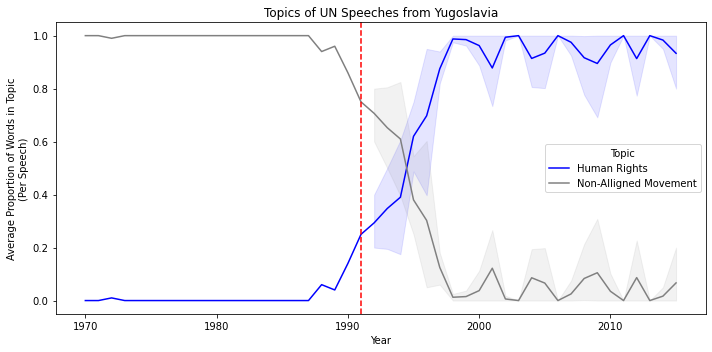

In [74]:
plt.figure(figsize = (10,5))

sns.lineplot(x = "Year", y = "Presence in Speeches", hue = "Topic", 
             data = df_year_yugo_long,
            palette = ["blue", "grey"],
             err_kws={'alpha':0.1})

plt.axvline(x = 1991,
           color = "red",
           linestyle = "--")

plt.title("Topics of UN Speeches from Yugoslavia")
plt.ylabel("Average Proportion of Words in Topic\n(Per Speech)")

plt.tight_layout()
plt.savefig("plots/yugo_topics.png", dpi = 400, width = 5, height = 3)

## East Asian

In [49]:
# Create dtm
X_asia = vec.fit_transform(df_fss["text"].loc[df_fss["country"].isin(["CHN", "KHM", "VNM", "LAO", "PRK"])])

In [50]:
# Create lda
lda_asia = LatentDirichletAllocation(n_components=3,
                                     n_jobs = -1,
                                     random_state = 1010)

In [51]:
# Fit lda
doc_topics_asia = lda_asia.fit_transform(X_asia)

In [52]:
interpret_topics(vec, lda_asia)

[['nuclear',
  'china',
  'war',
  'struggle',
  'chinese',
  'question',
  'super',
  'aggression',
  'disarmament',
  'south'],
 ['viet',
  'nam',
  'kampuchea',
  'vietnamese',
  'struggle',
  'independence',
  'democratic',
  'support',
  'asia',
  'aggression'],
 ['cooperation',
  'democratic',
  'nuclear',
  'china',
  'korea',
  'developing',
  'south',
  'efforts',
  'korean',
  'cambodia']]

In [53]:
# Name topics
topics_asia = ["nuclear_relations", "independence", "cooperation"]

### New Dataset

In [54]:
# Merge topics as proportions to documents
df_temp = df_fss.loc[df_fss["country"].isin(["CHN", "KHM", "VNM", "LAO", "PRK"])].reset_index(drop = True)
df_final_asia = topic_dataset(df_temp, topics_asia, X_asia, doc_topics_asia)

In [55]:
df_final_asia.sample(3)

,session,year,country,country_name,speaker,position,text,former_yugoslavia,former_ussr,socialist,Topic_nuclear_relations,Topic_independence,Topic_cooperation,top_topic
36,36,1981,LAO,Lao People's Democratic Republic,Mr. SIPRASEUT,NaN,"I should like first of all, Sir, to congratul...",0,0,1,0.00,0.94,0.06,1
46,39,1984,CHN,China,WU Xueqian,NaN,"﻿72. First of all, please allow me, Sir, on be...",0,0,1,0.78,0.00,0.22,0
194,70,2015,VNM,Viet Nam,Mrs. Nguyen Phuong Nga,Delegation,"On behalf of the Vietnamese delegation, I woul...",0,0,1,0.00,0.17,0.83,2


### Visualizations

#### Defining Each Topic

In [56]:
lda_asia_viz = pyLDAvis.sklearn.prepare(lda_model=lda_asia,
                                   dtm=X_asia,
                                   vectorizer=vec,
                                      sort_topics=False)

pyLDAvis.display(lda_asia_viz)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


#### Trends Over Time

In [57]:
# Drop particular columns
df_year_asia = df_final_asia.drop(["socialist"], axis = 1)

# Convert to long form
df_year_asia_long = long_form(df_year_asia)

C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/2785842549.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/east_asia_topics.png", dpi = 400, width = 5, height = 3)
C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/2785842549.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/east_asia_topics.png", dpi = 400, width = 5, height = 3)


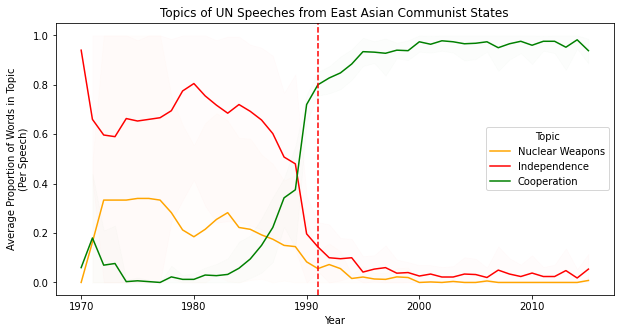

In [58]:
plt.figure(figsize = (10,5))

sns.lineplot(x = "Year", y = "Presence in Speeches", hue = "Topic", 
             data = df_year_asia_long,
            palette = ["orange", "red", "green"],
             err_kws={'alpha':0.01})

plt.axvline(x = 1991,
           color = "red",
           linestyle = "--")

plt.title("Topics of UN Speeches from East Asian Communist States")
plt.ylabel("Average Proportion of Words in Topic\n(Per Speech)")

plt.tight_layout()
plt.savefig("plots/east_asia_topics.png", dpi = 400, width = 5, height = 3)

## Africa & Carribean

In [59]:
# Creates a NEW vectorizer w/0 Africa, Grenada, or Cuba
vec = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(additional_stop_words))

In [60]:
# Subset countries
df_temp = df_fss.loc[~df_fss["country"].isin(["CHN", "KHM", "VNM", "LAO", "PRK", 
                                              "ALB", "MNG", "POL", "AFG", "BGR", 
                                              "CZE", "HUN", "ROU"] + ussr + yugo)].reset_index(drop = True)

In [61]:
# Create dtm
X_other = vec.fit_transform(df_temp["text"])

In [62]:
# Create lda
lda_other = LatentDirichletAllocation(n_components=2,
                                     n_jobs = -1,
                                     random_state = 1110)

In [63]:
# Fit lda
doc_topics_other = lda_other.fit_transform(X_other)

In [64]:
interpret_topics(vec, lda_other)

[['africa',
  'political',
  'efforts',
  'african',
  'human',
  'support',
  'process',
  'like',
  'somalia',
  'grenada'],
 ['independence',
  'struggle',
  'support',
  'africa',
  'situation',
  'southafrica',
  'state',
  'political',
  'war',
  'right']]

In [65]:
# Name topics
topics_other = ["development", "independence"]

### New Dataset

In [66]:
# Merge topics as proportions to documents
df_temp = df_fss.loc[~df_fss["country"].isin(["CHN", "KHM", "VNM", "LAO", "PRK", "ALB", 
                                              "MNG", "POL", "AFG", "BGR", "CZE", "HUN", "ROU"] + ussr + yugo)].reset_index(drop = True)
df_final_other = topic_dataset(df_temp, topics_other, X_other, doc_topics_other)

In [67]:
df_final_other.sample(3)

,session,year,country,country_name,speaker,position,text,former_yugoslavia,former_ussr,socialist,Topic_development,Topic_independence,top_topic
83,36,1981,ETH,Ethiopia,r. GEDLEGIORGIS,NaN,"94. M: Nearly 36 years ago, the United Nations...",0,0,1,0.00,1.00,1
336,66,2011,BEN,Benin,Nassirou Bako Arifari,Minister for Foreign Affairs,"I should like at the outset to convey to you,...",0,0,0,1.00,0.00,0
12,27,1972,ETH,Ethiopia,Mr. Haile,NaN,"It gives me great pleasure that you, Mr. Presi...",0,0,0,0.21,0.79,1


### Visualizations

#### Defining Each Topic

In [68]:
lda_other_viz = pyLDAvis.sklearn.prepare(lda_model=lda_other,
                                   dtm=X_other,
                                   vectorizer=vec,
                                      sort_topics=False)

pyLDAvis.display(lda_other_viz)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


#### Trends Over Time

In [69]:
# Drop particular columns
df_year_other = df_final_other.drop(["socialist"], axis = 1)

# Convert to long form
df_year_other_long = long_form(df_year_other)

C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/2674173548.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/africa_carribean_topics.png", dpi = 400, width = 5, height = 3)
C:\Users\Matt\AppData\Local\Temp/ipykernel_18516/2674173548.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("plots/africa_carribean_topics.png", dpi = 400, width = 5, height = 3)


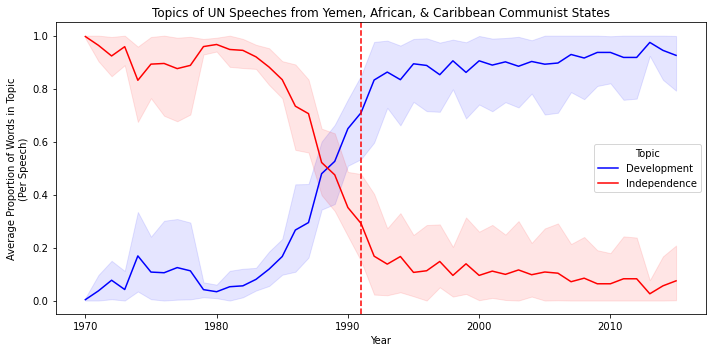

In [75]:
plt.figure(figsize = (10,5))

sns.lineplot(x = "Year", y = "Presence in Speeches", hue = "Topic", 
             data = df_year_other_long,
            palette = ["blue", "red"],
             err_kws={'alpha':0.1})

plt.axvline(x = 1991,
           color = "red",
           linestyle = "--")

plt.title("Topics of UN Speeches from Yemen, African, & Caribbean Communist States")
plt.ylabel("Average Proportion of Words in Topic\n(Per Speech)")

plt.tight_layout()
plt.savefig("plots/africa_carribean_topics.png", dpi = 400, width = 5, height = 3)

In [71]:
len(df_final_other)

380